In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
import plotly.graph_objects as go
import datetime
import matplotlib.pyplot as plt

Importation du csv dans un dataframe

In [2]:
df_ = pd.read_csv('../dataset/clean_online_retail.csv')
df = df_.copy()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 797815 entries, 0 to 797814
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      797815 non-null  object 
 1   StockCode    797815 non-null  object 
 2   Description  797815 non-null  object 
 3   Quantity     797815 non-null  int64  
 4   InvoiceDate  797815 non-null  object 
 5   Price        797815 non-null  float64
 6   Customer ID  797815 non-null  int64  
 7   Country      797815 non-null  object 
 8   TotalPrice   797815 non-null  float64
 9   cancelled    797815 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 60.9+ MB


In [5]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

In [6]:
# Filter the DataFrame based on the desired date range
df_2009_2010 = df[df['InvoiceDate'].dt.year <= 2010]

## Groupby Customer

In [7]:
df_gp_invoice = df_2009_2010.groupby(['Customer ID', 'Invoice']).sum(numeric_only=True).drop('Price', axis=1)
df_gp_invoice = df_gp_invoice[['Quantity', 'TotalPrice']]
df_gp_invoice


Quantity  TotalPrice
Customer ID Invoice                      
12346       491725         10       45.00
            491742          5       22.50
            491744          5       22.50
            492718          5       22.50
            492722          1        1.00
...                       ...         ...
18287       508581        732     1071.61
            523289        496      862.00
            523290         12       30.60
            534346        187      381.50
            C489592        -2       -5.10

[24392 rows x 2 columns]

### Pourcentage de retour par client

In [8]:
df_gp_cancellation = df_2009_2010.groupby("Customer ID").agg({"cancelled": "sum", "Invoice": "count"})

df_gp_cancellation = df_gp_cancellation.rename(columns={"cancelled": "TotalCancelled", "Invoice": "TotalInvoices"})

df_gp_cancellation["CancellationPercentage"] = (df_gp_cancellation["TotalCancelled"] / df_gp_cancellation["TotalInvoices"]) * 100

df_gp_cancellation.sort_values(by= "TotalCancelled", ascending=False)


,TotalCancelled,TotalInvoices,CancellationPercentage
Customer ID,,,
15311,178,2293,7.762756
14911,165,5863,2.814259
13798,129,540,23.888889
17511,110,1103,9.972801
14680,108,1155,9.350649
...,...,...,...
13754,0,9,0.000000
15899,0,4,0.000000
13753,0,45,0.000000


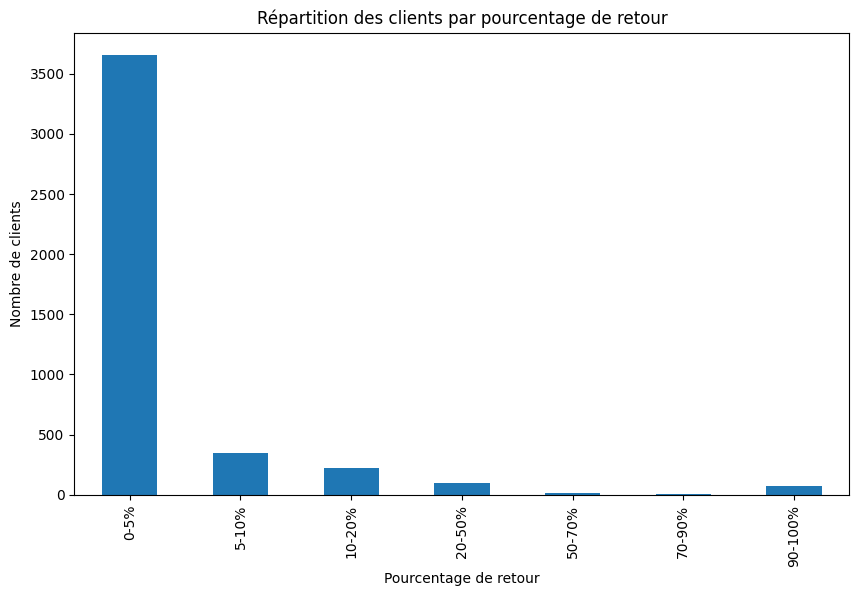

In [9]:
intervals = [0, 5, 10, 20, 50, 70, 90, 100]
labels = ['0-5%', '5-10%', '10-20%', '20-50%', '50-70%', '70-90%', '90-100%']

df_gp_cancellation['ReturnCategory'] = pd.cut(df_gp_cancellation['CancellationPercentage'], bins=intervals, labels=labels, right=True, include_lowest=True)

return_category_counts = df_gp_cancellation['ReturnCategory'].value_counts()

return_category_counts = return_category_counts.reindex(labels)

plt.figure(figsize=(10, 6))
return_category_counts.plot(kind='bar')
plt.xlabel('Pourcentage de retour')
plt.ylabel('Nombre de clients')
plt.title('Répartition des clients par pourcentage de retour')
plt.show()


La feature "CancellationPercentage" peut-être interessante à conserver dans le clustering

## Création du RFM

RFM ? Récence, Fréquence, Montant.

Récence : la date du dernier achat. Notez bien que l’on part du principe qu’une personne qui a acheté récemment chez vous a plus de chances de revenir commander chez vous.  

Fréquence : le nombre d’achats réalisé sur une période donnée. Plus un client achète régulièrement chez vous, plus il y a de chances pour qu’il achète à nouveau. Vous l’avez compris, on analyse ici son niveau de fidélité.  

Montant : la somme des achats cumulés sur une période donnée. Les gros acheteurs répondent mieux que les petits. On mesure ici la valeur client.

Trouver la date la plus récente

In [10]:
date_recente = df_2009_2010["InvoiceDate"].max()
print(date_recente)

2010-12-23 16:06:00


### Préparation des données RFM

In [11]:
last_date = df_2009_2010["InvoiceDate"].max()
recency = (last_date - df_2009_2010.groupby("Customer ID")["InvoiceDate"].max()).dt.days
frequency = df_2009_2010.groupby("Customer ID")["Invoice"].nunique()
monetary_value = df_2009_2010.groupby("Customer ID")["TotalPrice"].sum()

rfm_df = pd.DataFrame({
    "Recency": recency,
    "Frequency": frequency,
    "MonetaryValue": monetary_value
})

rfm_df.head(100)

,Recency,Frequency,MonetaryValue
Customer ID,,,
12346,79,15,-51.74
12347,16,2,1323.32
12348,6,2,1114.96
12349,56,4,2646.99
12351,24,1,300.93
...,...,...,...
12480,48,4,2153.47
12481,3,9,7258.13
12482,98,32,21893.53


On va adapter cette analyse RFM à notre dataset pour la rendre plus spécifique et plus parlante

In [12]:
df_rfm_spe = df_2009_2010.groupby('Customer ID').agg({'Invoice': 'nunique','Quantity':'sum', 'TotalPrice':'sum'})
df_rfm_spe.columns = ['TotalInvoices', 'TotalQuantity', 'TotalPrice']
df_rfm_spe = df_rfm_spe.merge(rfm_df["Recency"], on="Customer ID")
df_rfm_spe = df_rfm_spe.merge(df_gp_cancellation["CancellationPercentage"], on="Customer ID")

df_rfm_spe

,TotalInvoices,TotalQuantity,TotalPrice,Recency,CancellationPercentage
Customer ID,,,,,
12346,15,53,-51.74,79,26.666667
12347,2,828,1323.32,16,0.000000
12348,2,1627,1114.96,6,0.000000
12349,4,988,2646.99,56,4.672897
12351,1,261,300.93,24,0.000000
...,...,...,...,...,...
18283,6,322,619.37,31,0.000000
18284,2,493,436.68,78,3.448276
18285,1,145,427.00,309,0.000000


Dans le nettoyage, nous avions essayé d'identifier des grossistes, mais il était difficle de les différentier d'autres types de clients (ceux qui organisent des évènements d'entreprise par exemple)

On va donc plutôt s'interesser au nombre d'article moyen par commande par client

In [13]:
df_gp_nb_articles_mean = df_2009_2010.groupby(['Customer ID', 'Invoice']).agg({'Quantity': 'sum'})
df_gp_nb_articles_mean = df_gp_nb_articles_mean.groupby('Customer ID').mean()

df_gp_nb_articles_mean.columns=['AvgItemsPerOrder']

df_gp_nb_articles_mean

,AvgItemsPerOrder
Customer ID,
12346,3.533333
12347,414.000000
12348,813.500000
12349,247.000000
12351,261.000000
...,...
18283,53.666667
18284,246.500000
18285,145.000000


In [14]:
df_rfm_spe = df_rfm_spe.merge(df_gp_nb_articles_mean["AvgItemsPerOrder"], on="Customer ID")
df_rfm_spe

,TotalInvoices,TotalQuantity,TotalPrice,Recency,CancellationPercentage,AvgItemsPerOrder
Customer ID,,,,,,
12346,15,53,-51.74,79,26.666667,3.533333
12347,2,828,1323.32,16,0.000000,414.000000
12348,2,1627,1114.96,6,0.000000,813.500000
12349,4,988,2646.99,56,4.672897,247.000000
12351,1,261,300.93,24,0.000000,261.000000
...,...,...,...,...,...,...
18283,6,322,619.37,31,0.000000,53.666667
18284,2,493,436.68,78,3.448276,246.500000
18285,1,145,427.00,309,0.000000,145.000000


In [15]:
df_rfm_spe.describe()

,TotalInvoices,TotalQuantity,TotalPrice,Recency,CancellationPercentage,AvgItemsPerOrder
count,4411.000000,4411.000000,4411.000000,4411.000000,4411.000000,4411.000000
mean,5.529812,1237.172977,1941.470579,99.202675,4.362482,209.041138
std,10.405310,6232.787992,8646.164289,99.797324,14.033592,1419.811723
min,1.000000,-1535.000000,-25111.090000,0.000000,0.000000,-393.000000
25%,1.000000,145.000000,285.570000,26.500000,0.000000,72.000000
50%,3.000000,370.000000,664.001000,60.000000,0.000000,124.600000
75%,6.000000,970.500000,1666.225000,143.500000,2.816901,213.600000
max,278.000000,218090.000000,341776.730000,387.000000,100.000000,87167.000000


On décide, pour enlever les clients trop spéficiques (organisation d'evenements, grossistes, etc ), d'éliminer les 2% de clients avec les plus d'articles par paniers.

In [16]:
df_rfm_filtered = df_rfm_spe[df_rfm_spe['AvgItemsPerOrder'] <= df_rfm_spe['AvgItemsPerOrder'].quantile(0.98)]

df_rfm_filtered

,TotalInvoices,TotalQuantity,TotalPrice,Recency,CancellationPercentage,AvgItemsPerOrder
Customer ID,,,,,,
12346,15,53,-51.74,79,26.666667,3.533333
12347,2,828,1323.32,16,0.000000,414.000000
12349,4,988,2646.99,56,4.672897,247.000000
12351,1,261,300.93,24,0.000000,261.000000
12352,2,188,343.80,24,0.000000,94.000000
...,...,...,...,...,...,...
18283,6,322,619.37,31,0.000000,53.666667
18284,2,493,436.68,78,3.448276,246.500000
18285,1,145,427.00,309,0.000000,145.000000


Supprimer les valeurs abérrantes permet de préserver l'homogénéité des segments,améliorer la stabilité et cohérence des clusters et réduire l'impact des erreurs de mesure ou des valeurs manquantes.

Cependant, les valeurs aberrantes peuvent représenter des comportements d'achat inhabituels mais légitimes, ou bien des erreurs de saisie ou des données corrompues. Supprimer systématiquement toutes les valeurs aberrantes peut entraîner une perte d'informations précieuses et fausser l'analyse.

Il peut être utile de consulter les spécialistes métier ou de mener des investigations supplémentaires pour obtenir des informations plus détaillées. On décide donc pour la suite de conserver les données en l'état actuel.

In [17]:
df_rfm_spe.to_csv('../dataset/rfm_2009-2010.csv')

In [18]:
df_rfm_filtered.to_csv('../dataset/rfm_filtered_2009-2010.csv')

In [20]:
df_rfm_spe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4411 entries, 12346 to 18287
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   TotalInvoices           4411 non-null   int64  
 1   TotalQuantity           4411 non-null   int64  
 2   TotalPrice              4411 non-null   float64
 3   Recency                 4411 non-null   int64  
 4   CancellationPercentage  4411 non-null   float64
 5   AvgItemsPerOrder        4411 non-null   float64
dtypes: float64(3), int64(3)
memory usage: 241.2 KB
